<a href="https://colab.research.google.com/github/Canihelpme/DeepLearning_finance/blob/main/Various_model_to_predict_Kospi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from pathlib import Path

folder = ""
project_dir = ""

base_path = Path("/content/drive/My Drive/")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/drive/My Drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Input, RepeatVector, TimeDistributed, Flatten, Dropout, MaxPooling1D, Activation, LeakyReLU, PReLU
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import IPython
import IPython.display

%matplotlib inline
warnings.filterwarnings('ignore')

In [4]:
filename = '/content/drive/MyDrive/Financial_data/Data/train/kospi_train_data.csv'
data = pd.read_csv(filename, sep=",",encoding='UTF-8')
data.head()

,Date,End,Open,High,Low,Amount,Val
0,2020년 02월 21일,"2,162.84","2,165.65","2,184.43","2,160.28",635.47M,-1.49%
1,2020년 02월 20일,"2,195.50","2,223.55","2,228.18","2,186.72",709.56M,-0.67%
2,2020년 02월 19일,"2,210.34","2,222.51","2,226.00","2,191.20",591.16M,0.07%
3,2020년 02월 18일,"2,208.88","2,225.98","2,232.93","2,205.21",470.42M,-1.48%
4,2020년 02월 17일,"2,242.17","2,243.07","2,250.05","2,230.26",458.25M,-0.06%


In [5]:
date_index = data
date_index = date_index.copy()

In [6]:
date_index['Date'] = date_index.Date.apply(str).str.replace("년","").str.replace("월","").str.replace("일","")
date_index['Date'] = date_index.Date.str.replace(" ","")

date_index['Amount'] = date_index.Amount.apply(str).str.replace("B", "0000000").str.replace("M","0000").str.replace("K","0").str.replace(".","")
date_index['Amount'] = date_index.Amount.astype(int)
date_index['Val'] = date_index.Val.apply(str).str.replace("%", "")
date_index['Val'] = date_index.Val.astype(float)
date_index['End'] = date_index.End.apply(str).str.replace(",","").astype(float)
date_index['Open'] = date_index.Open.apply(str).str.replace(",","").astype(float)
date_index['High'] = date_index.High.apply(str).str.replace(",","").astype(float)
date_index['Low'] = date_index.Low.apply(str).str.replace(",","").astype(float)

date_index = date_index.loc[::-1].reset_index(drop=True)
date_time = pd.to_datetime(date_index.pop('Date'))
date_index.tail()


,End,Open,High,Low,Amount,Val
10383,2242.17,2243.07,2250.05,2230.26,458250000,-0.06
10384,2208.88,2225.98,2232.93,2205.21,470420000,-1.48
10385,2210.34,2222.51,2226.00,2191.20,591160000,0.07
10386,2195.50,2223.55,2228.18,2186.72,709560000,-0.67
10387,2162.84,2165.65,2184.43,2160.28,635470000,-1.49


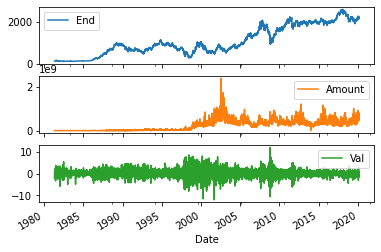

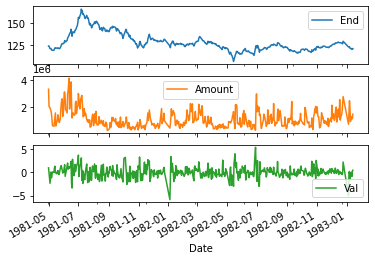

In [7]:
plot_cols = ['End', 'Amount', 'Val']
plot_features = date_index[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)
#전체적인 데이터 출력
plot_features = date_index[plot_cols][:500]
plot_features.index = date_time[:500]
_ = plot_features.plot(subplots=True)
#데이터의 일부분만 출력하여 데이터의 특성을 추출
#Val, Amount의 경우 가끔 Shooting이 일어나는 값을 제외하고 일정한 범위내에 존재 함

In [9]:
print(date_index)
print(date_index.shape)

           End     Open     High      Low     Amount   Val
0       123.60   123.60   123.60   123.60    3330000  0.98
1       123.50   123.50   123.50   123.50    2040000 -0.08
2       120.60   120.60   120.60   120.60    1930000 -2.35
3       120.70   120.70   120.70   120.70    1690000  0.08
4       119.30   119.30   119.30   119.30    1480000 -1.16
...        ...      ...      ...      ...        ...   ...
10383  2242.17  2243.07  2250.05  2230.26  458250000 -0.06
10384  2208.88  2225.98  2232.93  2205.21  470420000 -1.48
10385  2210.34  2222.51  2226.00  2191.20  591160000  0.07
10386  2195.50  2223.55  2228.18  2186.72  709560000 -0.67
10387  2162.84  2165.65  2184.43  2160.28  635470000 -1.49

[10388 rows x 6 columns]
(10388, 6)


In [8]:
date_index.describe()

,End,Open,High,Low,Amount,Val
count,10388.000000,10388.000000,10388.000000,10388.000000,1.038800e+04,10388.000000
mean,1028.213099,1028.629756,1033.878016,1022.224383,2.175911e+08,0.038568
std,683.773007,684.222797,687.160231,679.985052,2.371764e+08,1.457766
min,105.990000,105.990000,105.990000,105.990000,1.660000e+05,-12.020000
25%,565.195000,565.175000,569.615000,558.530000,1.038000e+07,-0.622500
50%,847.615000,847.860000,853.475000,840.665000,1.765450e+08,0.030000
75%,1720.612500,1721.410000,1732.810000,1707.807500,3.758325e+08,0.712500
max,2598.190000,2590.410000,2607.100000,2587.550000,2.380000e+09,11.950000


In [11]:
column_indices = {name: i for i, name in enumerate(date_index.columns)}

n = len(date_index)
train_df = date_index[0:int(n*0.7)]
val_df = date_index[int(n*0.7):int(n*0.9)]
test_df = date_index[int(n*0.9):]

num_features = date_index.shape[1]

In [12]:
print(train_df)

          End     Open     High      Low     Amount   Val
0      123.60   123.60   123.60   123.60    3330000  0.98
1      123.50   123.50   123.50   123.50    2040000 -0.08
2      120.60   120.60   120.60   120.60    1930000 -2.35
3      120.70   120.70   120.70   120.70    1690000  0.08
4      119.30   119.30   119.30   119.30    1480000 -1.16
...       ...      ...      ...      ...        ...   ...
7266  1847.79  1841.56  1865.52  1836.93  534040000  0.51
7267  1861.01  1855.03  1863.01  1838.75  414380000  0.72
7268  1883.59  1870.35  1890.83  1865.79  430590000  1.21
7269  1894.53  1887.35  1895.98  1881.36  406270000  0.58
7270  1889.96  1880.71  1904.35  1875.43  473880000 -0.24

[7271 rows x 6 columns]


In [13]:
train_mean = train_df.mean()
train_std = train_df.std()

#Min-Max Scaling
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [15]:
print(train_df)
print(val_df)

           End      Open      High       Low    Amount       Val
0    -1.474065 -1.474174 -1.475191 -1.473744 -0.595490  0.601218
1    -1.474352 -1.474461 -1.475477 -1.474034 -0.601059 -0.084041
2    -1.482694 -1.482802 -1.483768 -1.482432 -0.601533 -1.551530
3    -1.482406 -1.482514 -1.483482 -1.482143 -0.602569  0.019394
4    -1.486433 -1.486541 -1.487484 -1.486197 -0.603476 -0.782230
...        ...       ...       ...       ...       ...       ...
7266  3.485398  3.466699  3.504494  3.488076  1.695228  0.297377
7267  3.523424  3.505439  3.497318  3.493347  1.178736  0.433136
7268  3.588373  3.549499  3.576848  3.571655  1.248704  0.749906
7269  3.619841  3.598392  3.591571  3.616746  1.143730  0.342630
7270  3.606695  3.579295  3.615498  3.599573  1.435557 -0.187477

[7271 rows x 6 columns]
           End      Open      High       Low    Amount           Val
7271  3.663619  3.627842  3.666670  3.663748  1.313233  6.464709e-01
7272  3.816586  3.767300  3.782992  3.791057  1.580974  1

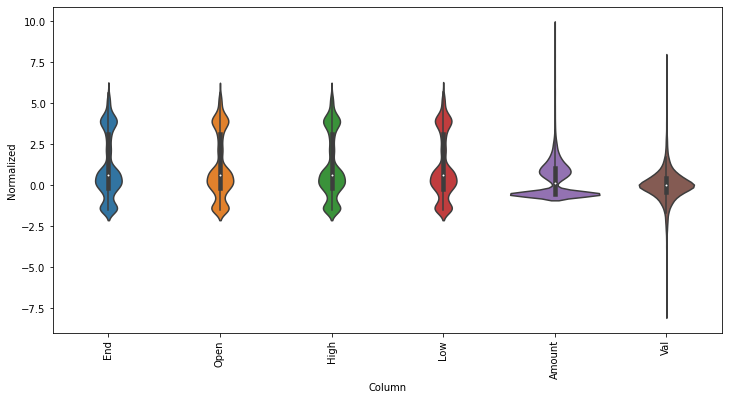

In [16]:
df_std = (date_index - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(date_index.keys(), rotation=90)

##Stacked Autoencoder

In [17]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(6, activation = 'relu', input_shape = (6,)),
    tf.keras.layers.Dense(4, activation = 'relu'),
    tf.keras.layers.Dense(2, activation = None)
])

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(4, activation = 'relu', input_shape = (2,)),
    tf.keras.layers.Dense(6, activation = 'relu'),
    tf.keras.layers.Dense(6, activation = None)
])

autoencoder = tf.keras.models.Sequential([encoder, decoder])

In [18]:
autoencoder.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                    loss = 'mean_squared_error',
                    metrics = ['mse', "accuracy"])

In [19]:
training = autoencoder.fit(train_df,train_df, batch_size = 30, epochs = 50, validation_data=(val_df, val_df))

Epoch 1/50
243/243 [==============================] - 2s 4ms/step - loss: 0.8101 - mse: 0.8101 - accuracy: 0.3627 - val_loss: 7.8673 - val_mse: 7.8673 - val_accuracy: 0.3022
Epoch 2/50
243/243 [==============================] - 1s 3ms/step - loss: 0.5320 - mse: 0.5320 - accuracy: 0.3522 - val_loss: 6.8204 - val_mse: 6.8204 - val_accuracy: 0.3022
Epoch 3/50
243/243 [==============================] - 1s 3ms/step - loss: 0.4617 - mse: 0.4617 - accuracy: 0.3707 - val_loss: 6.0841 - val_mse: 6.0841 - val_accuracy: 0.3258
Epoch 4/50
243/243 [==============================] - 1s 3ms/step - loss: 0.4199 - mse: 0.4199 - accuracy: 0.4215 - val_loss: 5.5239 - val_mse: 5.5239 - val_accuracy: 0.3258
Epoch 5/50
243/243 [==============================] - 1s 3ms/step - loss: 0.3451 - mse: 0.3451 - accuracy: 0.5411 - val_loss: 4.9971 - val_mse: 4.9971 - val_accuracy: 0.3292
Epoch 6/50
243/243 [==============================] - 1s 3ms/step - loss: 0.2352 - mse: 0.2352 - accuracy: 0.6497 - val_loss: 3.26

In [20]:
test_scores = autoencoder.evaluate(train_df, train_df, verbose = 2)
print('Test loss: {}'.format(test_scores[0]))
print('Mean Squared Error: {} %'.format(test_scores[1]*100))

228/228 - 0s - loss: 0.0455 - mse: 0.0455 - accuracy: 0.7458 - 324ms/epoch - 1ms/step
Test loss: 0.04554596543312073
Mean Squared Error: 4.554596543312073 %


In [21]:
print(training.history['val_loss'])


[7.8673176765441895, 6.820385932922363, 6.084059715270996, 5.523942470550537, 4.997104167938232, 3.2688355445861816, 2.036226272583008, 1.5244454145431519, 1.2625805139541626, 1.0843279361724854, 0.9510291218757629, 0.8486945033073425, 0.7886903285980225, 0.716254711151123, 0.666237473487854, 0.6252828240394592, 0.5813168287277222, 0.48525547981262207, 0.44262272119522095, 0.4651377499103546, 0.43462467193603516, 0.4114122986793518, 0.3773338794708252, 0.363556444644928, 0.38612452149391174, 0.3638620972633362, 0.35103118419647217, 0.3504664897918701, 0.32714414596557617, 0.33790791034698486, 0.3304102122783661, 0.3584897220134735, 0.32664260268211365, 0.33216843008995056, 0.3177221119403839, 0.3266995847225189, 0.3106312155723572, 0.31017032265663147, 0.314518541097641, 0.2952723801136017, 0.3232375979423523, 0.34289678931236267, 0.31184694170951843, 0.2981191575527191, 0.3066308796405792, 0.28558602929115295, 0.2912057638168335, 0.2760988175868988, 0.30376413464546204, 0.272722214460

No handles with labels found to put in legend.


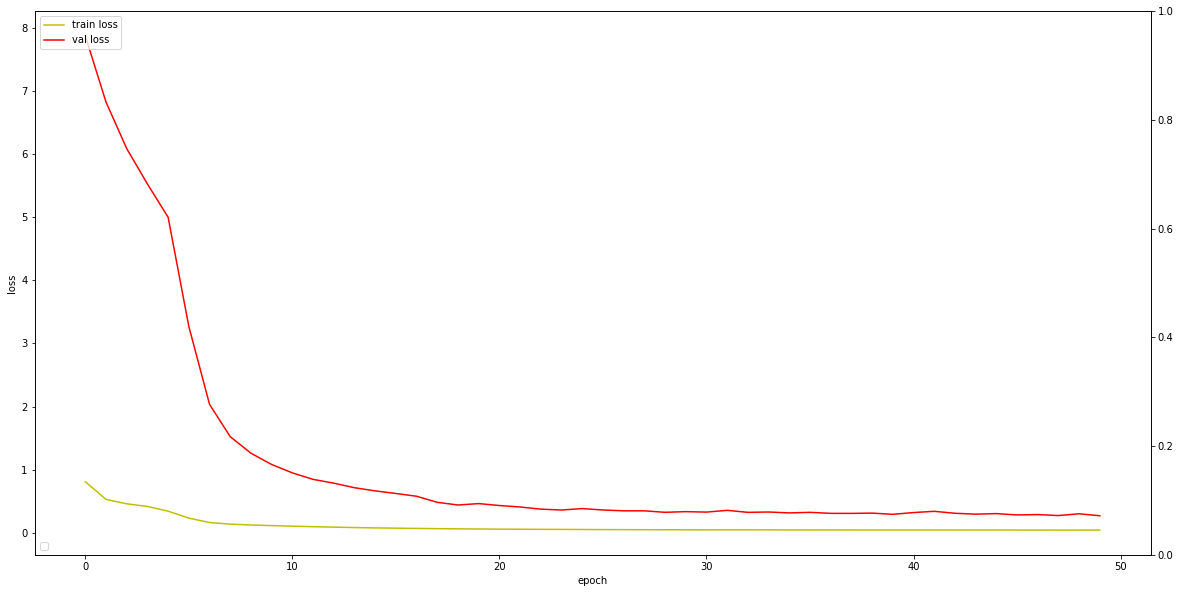

In [22]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(training.history['loss'], 'y', label = 'train loss')
loss_ax.plot(training.history['val_loss'], 'r', label = 'val loss')

#acc_ax.plot(training.history['accuracy'], 'b', label = 'train accuracy')
#acc_ax.plot(training.history['val_accuracy'], 'g', label = 'valid accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
#acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

fig.set_size_inches(20,10)
plt.show()

In [23]:
autoencoder_result = autoencoder.predict(train_df, verbose=0)
print(np.round(autoencoder_result,20))

[[-1.4028472  -1.4104218  -1.4055719  -1.4094898  -0.5909848   0.5362412 ]
 [-1.4166688  -1.4154747  -1.4134414  -1.4208578  -0.56929326 -0.17423356]
 [-1.4539863  -1.4340601  -1.4380145  -1.4529783  -0.5232192  -1.6929969 ]
 ...
 [ 3.4045143   3.384391    3.405166    3.375839    1.5939494   0.506884  ]
 [ 3.4456253   3.4283855   3.446914    3.41965     1.4897019   0.32840085]
 [ 3.5069063   3.4918704   3.5095327   3.4819162   1.5665241   0.17994344]]


In [24]:
autoencoder_result_df = pd.DataFrame(autoencoder_result)
autoencoder_result_df.columns = ["End", "Open", "High", "Low", "Amount", "Val"]
train_df = autoencoder_result_df
train_df

,End,Open,High,Low,Amount,Val
0,-1.402847,-1.410422,-1.405572,-1.409490,-0.590985,0.536241
1,-1.416669,-1.415475,-1.413441,-1.420858,-0.569293,-0.174234
2,-1.453986,-1.434060,-1.438015,-1.452978,-0.523219,-1.692997
3,-1.422459,-1.422591,-1.420102,-1.427064,-0.572839,-0.067844
4,-1.442318,-1.432214,-1.432999,-1.444079,-0.547646,-0.897627
...,...,...,...,...,...,...
7266,3.492004,3.477154,3.493888,3.468160,1.410054,0.175138
7267,3.423928,3.407459,3.425055,3.399132,1.409095,0.293133
7268,3.404514,3.384391,3.405166,3.375839,1.593950,0.506884
7269,3.445625,3.428385,3.446914,3.419650,1.489702,0.328401


#인덱스 및 오프셋

In [25]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

7일간의 입력으로 1일의 예측치 생성

In [26]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                   label_columns=['End'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['End']

#분할
Split_window가 입력 창과 레이블 창으로 변환


In [27]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [28]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)
print(w2.total_window_size)
print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}') #특성, 시간, 여러 예제

7
All shapes are: (batch, time, features)
Window shape: (3, 7, 6)
Inputs shape: (3, 6, 6)
labels shape: (3, 1, 1)


In [29]:
w2.example = example_inputs, example_labels


In [30]:
def plot(self, model=None, plot_col='End', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Day')

WindowGenerator.plot = plot

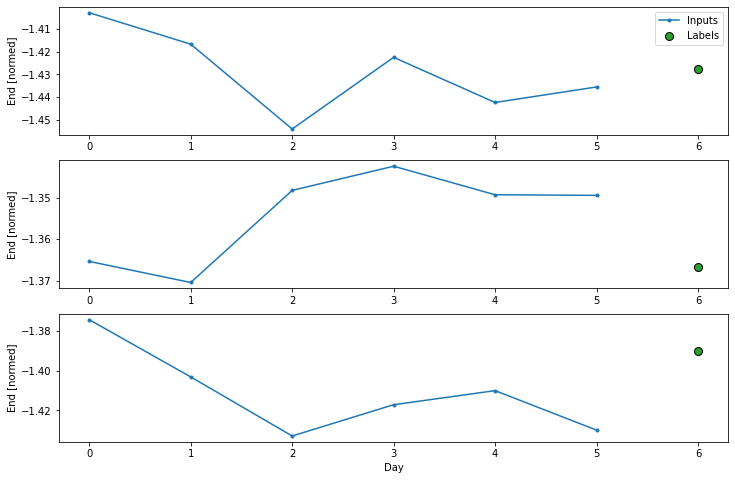

In [31]:
w2.plot()


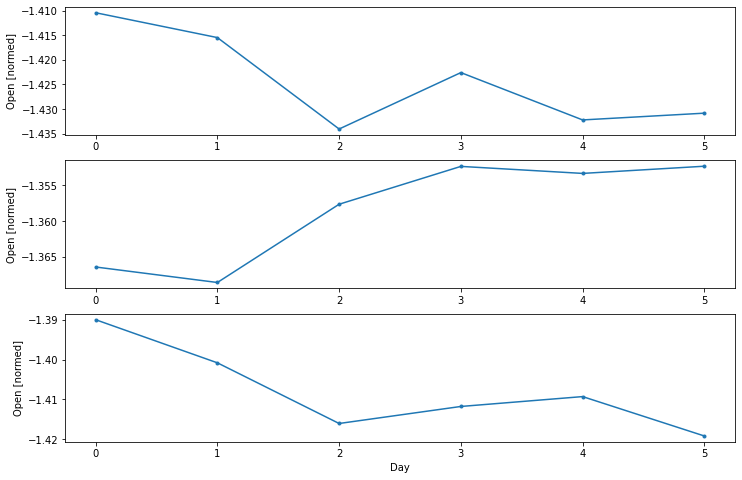

In [32]:
w2.plot(plot_col='Open')

In [33]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [34]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [35]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 6), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [36]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 6)
Labels shape (batch, time, features): (32, 1, 1)


In [37]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['End'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['End']

In [38]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 6)
Labels shape (batch, time, features): (32, 1, 1)


In [39]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [40]:
baseline = Baseline(label_index=column_indices['End'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

65/65 [==============================] - 0s 4ms/step - loss: 0.0042 - mean_absolute_error: 0.0459


In [41]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['End'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['End']

In [42]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 6)
Output shape: (32, 1, 1)


In [43]:
print('Input shape:',wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 6)
Output shape: (32, 24, 1)


Single step

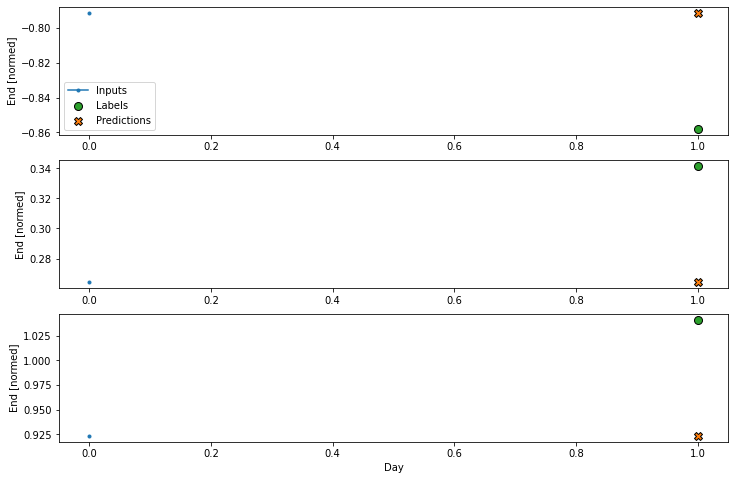

In [44]:
single_step_window.plot(baseline)

Wide_window 예측(baseline)

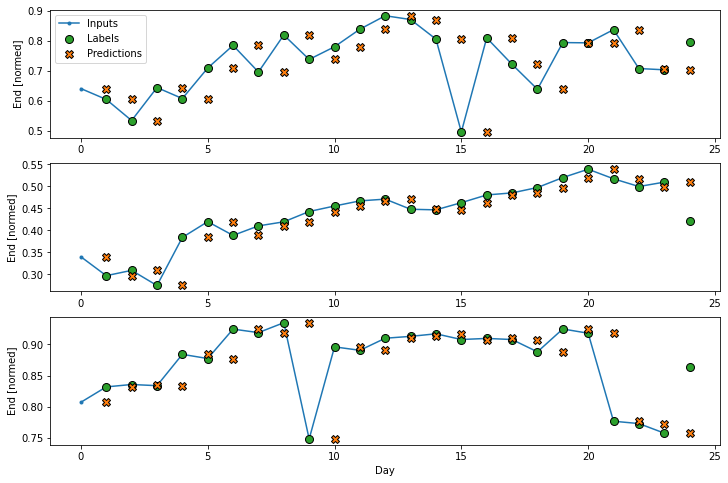

In [45]:
wide_window.plot(baseline)

In [46]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [47]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 6)
Output shape: (32, 1, 1)


Model 제작 후 Single window로 예측

In [48]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [49]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
228/228 [==============================] - 2s 7ms/step - loss: 0.1048 - mean_absolute_error: 0.2189 - val_loss: 0.0388 - val_mean_absolute_error: 0.1446
Epoch 2/20
228/228 [==============================] - 2s 8ms/step - loss: 0.0405 - mean_absolute_error: 0.1264 - val_loss: 0.0131 - val_mean_absolute_error: 0.0928
Epoch 3/20
228/228 [==============================] - 1s 6ms/step - loss: 0.0250 - mean_absolute_error: 0.0878 - val_loss: 0.0073 - val_mean_absolute_error: 0.0695
Epoch 4/20
228/228 [==============================] - 1s 6ms/step - loss: 0.0225 - mean_absolute_error: 0.0792 - val_loss: 0.0074 - val_mean_absolute_error: 0.0701
Epoch 5/20
228/228 [==============================] - 1s 6ms/step - loss: 0.0223 - mean_absolute_error: 0.0790 - val_loss: 0.0070 - val_mean_absolute_error: 0.0665
Epoch 6/20
228/228 [==============================] - 1s 6ms/step - loss: 0.0223 - mean_absolute_error: 0.0791 - val_loss: 0.0075 - val_mean_absolute_error: 0.0698
Epoch 7/20
65/65

Wide window로 예측

In [50]:
history = compile_and_fit(linear, wide_window)

val_performance['Linear'] = linear.evaluate(wide_window.val)
performance['Linear'] = linear.evaluate(wide_window.test, verbose=0)

Epoch 1/20
227/227 [==============================] - 3s 9ms/step - loss: 0.0223 - mean_absolute_error: 0.0792 - val_loss: 0.0068 - val_mean_absolute_error: 0.0658
Epoch 2/20
227/227 [==============================] - 2s 8ms/step - loss: 0.0223 - mean_absolute_error: 0.0792 - val_loss: 0.0072 - val_mean_absolute_error: 0.0677
Epoch 3/20
65/65 [==============================] - 0s 5ms/step - loss: 0.0073 - mean_absolute_error: 0.0685


In [51]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 6)
Output shape: (32, 24, 1)


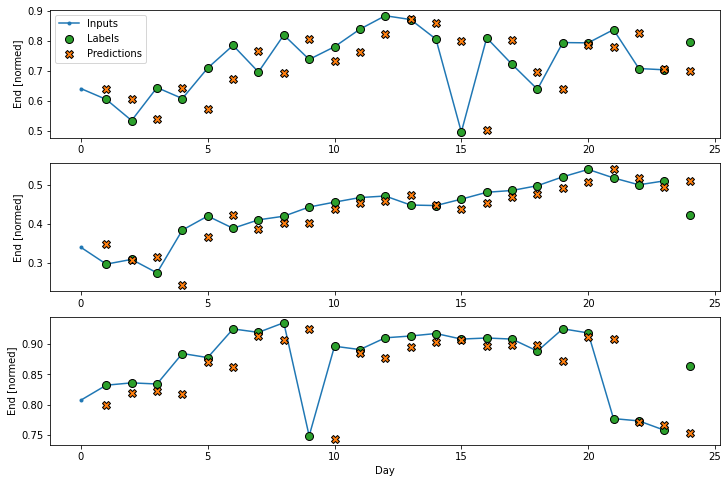

In [52]:
wide_window.plot(linear)


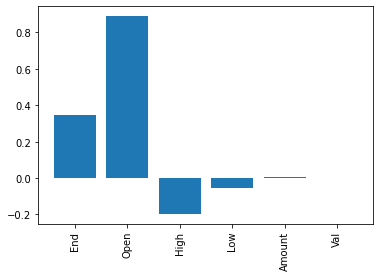

In [53]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [54]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
228/228 [==============================] - 5s 17ms/step - loss: 0.0583 - mean_absolute_error: 0.1219 - val_loss: 0.0125 - val_mean_absolute_error: 0.0809
Epoch 2/20
228/228 [==============================] - 2s 7ms/step - loss: 0.0209 - mean_absolute_error: 0.0790 - val_loss: 0.0385 - val_mean_absolute_error: 0.1780
Epoch 3/20
228/228 [==============================] - 2s 8ms/step - loss: 0.0207 - mean_absolute_error: 0.0793 - val_loss: 0.0086 - val_mean_absolute_error: 0.0639
Epoch 4/20
228/228 [==============================] - 2s 7ms/step - loss: 0.0204 - mean_absolute_error: 0.0774 - val_loss: 0.0149 - val_mean_absolute_error: 0.0999
Epoch 5/20
65/65 [==============================] - 0s 5ms/step - loss: 0.0095 - mean_absolute_error: 0.0714


Convolution network

In [55]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['End'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['End']

Text(0.5, 1.0, 'Given 3day as input, predict 1day into the future.')

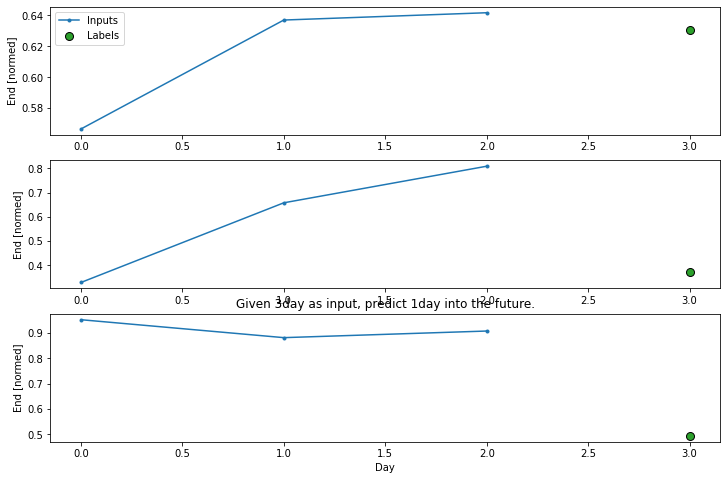

In [56]:
conv_window.plot()
plt.title("Given 3day as input, predict 1day into the future.")

In [57]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [58]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 6)
Output shape: (32, 1, 1)


In [59]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

65/65 [==============================] - 0s 5ms/step - loss: 0.0102 - mean_absolute_error: 0.0826


In [60]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 6)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [61]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['End'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['End']

In [62]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 6)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


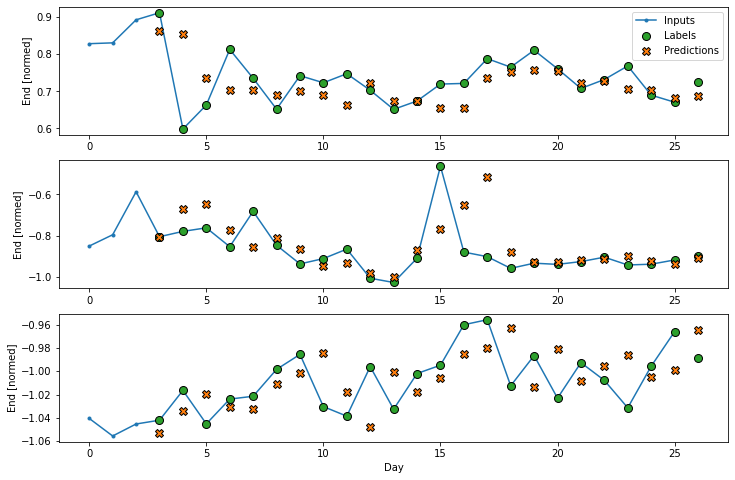

In [63]:
wide_conv_window.plot(conv_model)

RNN

In [64]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [65]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 6)
Output shape: (32, 24, 1)


In [66]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

65/65 [==============================] - 1s 7ms/step - loss: 0.1133 - mean_absolute_error: 0.2843


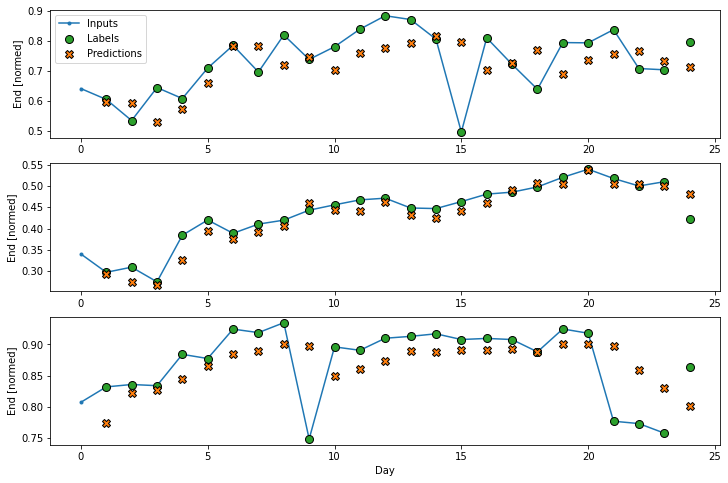

In [67]:
wide_window.plot(lstm_model)

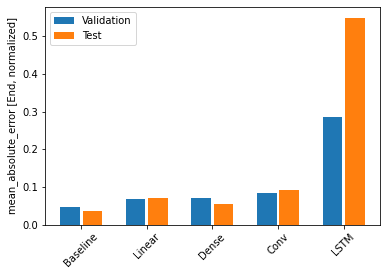

In [68]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [End, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
fig.set_size_inches(20,10)
_ = plt.legend()

In [69]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0361
Linear      : 0.0709
Dense       : 0.0547
Conv        : 0.0929
LSTM        : 0.5494


#다중스텝모델

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

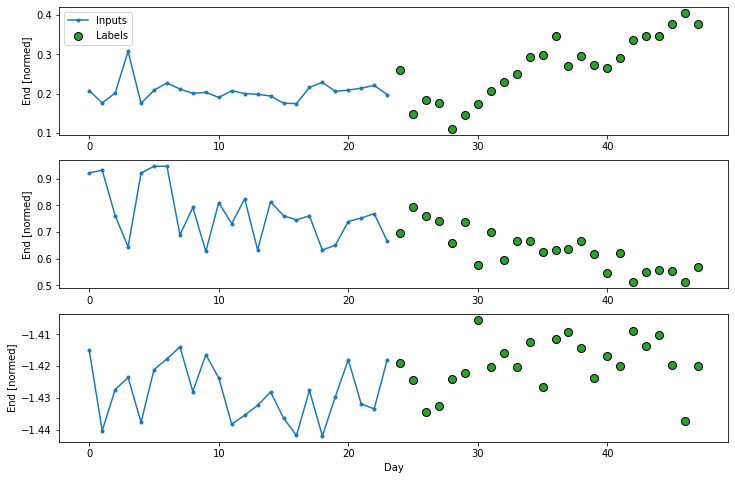

In [70]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

#Baseline
간단한 기준은 필요한 출력 타임스텝 수에 대해 마지막 입력 타임스텝을 반복

64/64 [==============================] - 0s 5ms/step - loss: 0.3432 - mean_absolute_error: 0.3065


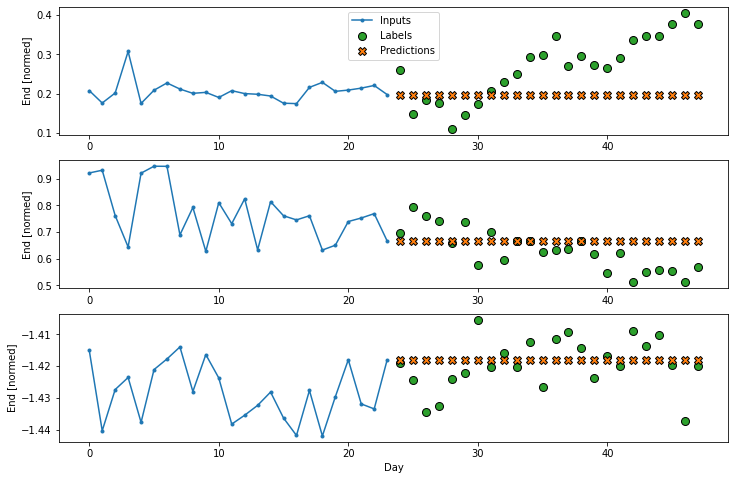

In [88]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Baseline'] = last_baseline.evaluate(multi_window.val)
multi_performance['Baseline'] = last_baseline.evaluate(multi_window.val, verbose=0)
multi_window.plot(last_baseline)

64/64 [==============================] - 0s 4ms/step - loss: 0.3834 - mean_absolute_error: 0.3658


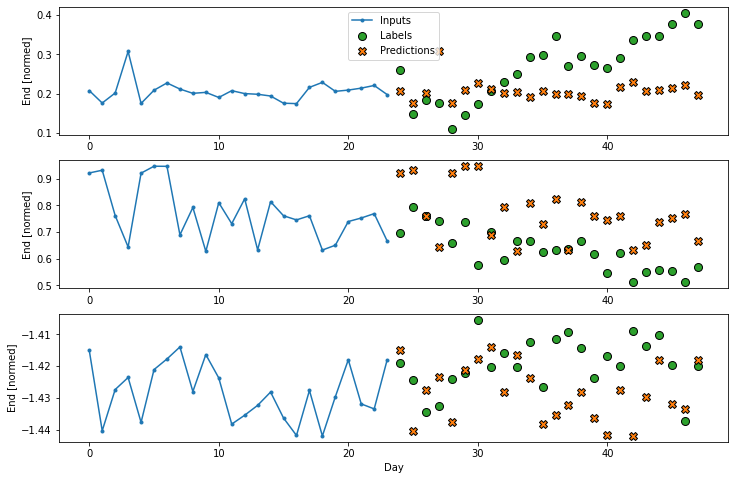

In [89]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

#싱글샷 모델
한 번에 전체 시퀀스 예측을 수행하는 "싱글샷" 모델

linear model

64/64 [==============================] - 1s 8ms/step - loss: 0.2070 - mean_absolute_error: 0.2642


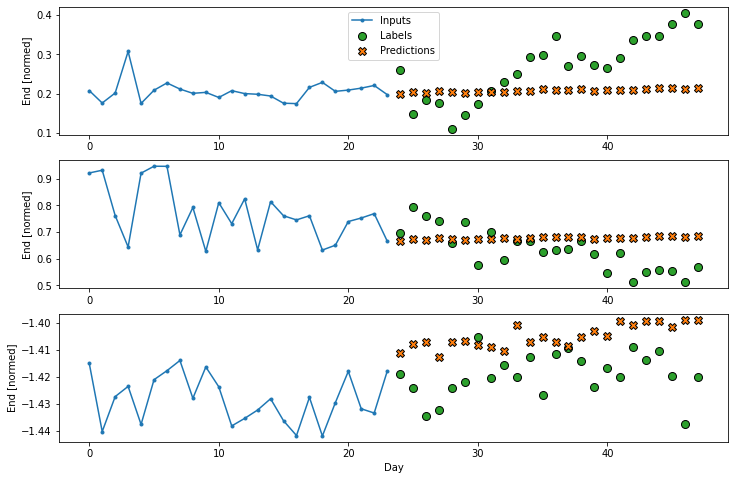

In [90]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

밀집 모델
입력과 출력 사이에 layers.Dense를 추가하면 선형 모델이 더 강력해지지만 여전히 단일 입력에 기반합니다.

64/64 [==============================] - 0s 5ms/step - loss: 0.2591 - mean_absolute_error: 0.3348


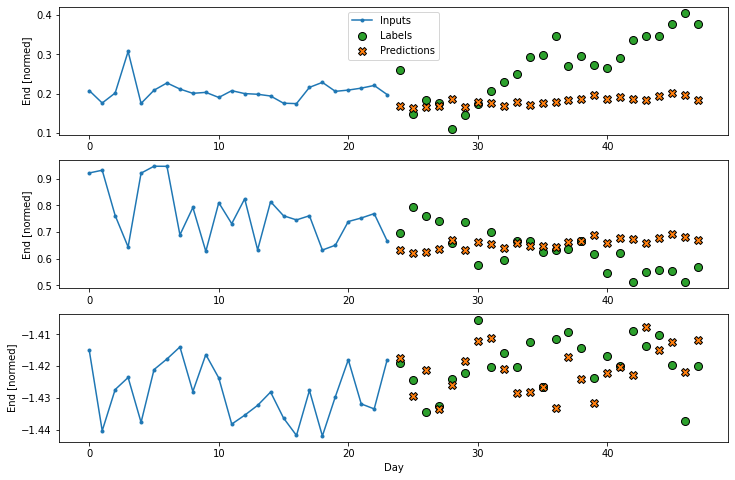

In [91]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

Cnn

64/64 [==============================] - 0s 4ms/step - loss: 0.2680 - mean_absolute_error: 0.3561


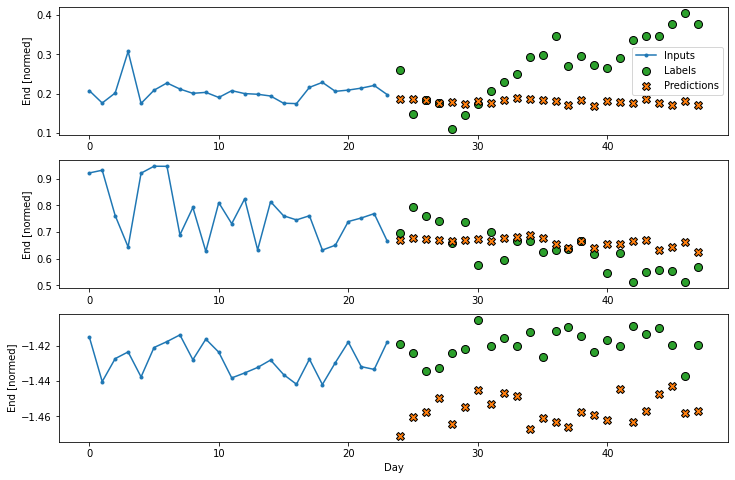

In [92]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

RNN

64/64 [==============================] - 0s 6ms/step - loss: 0.4628 - mean_absolute_error: 0.5435


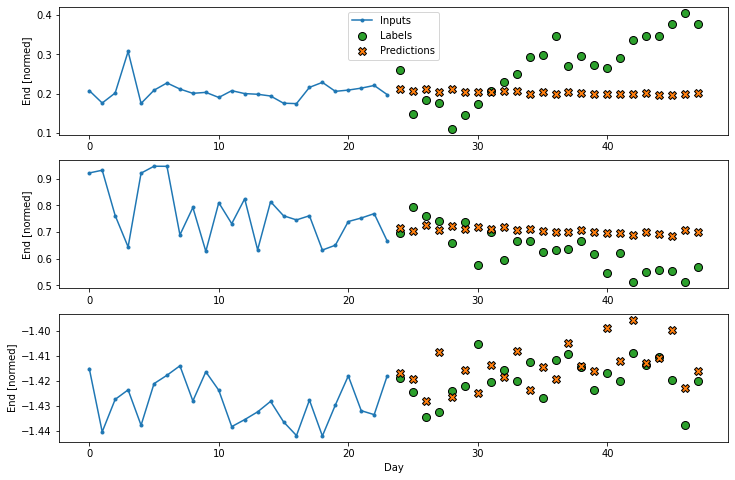

In [93]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

AR LSTM

In [94]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [95]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)


In [96]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [97]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 6])

In [98]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [99]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 6)


64/64 [==============================] - 1s 8ms/step - loss: 0.4629 - mean_absolute_error: 0.5474


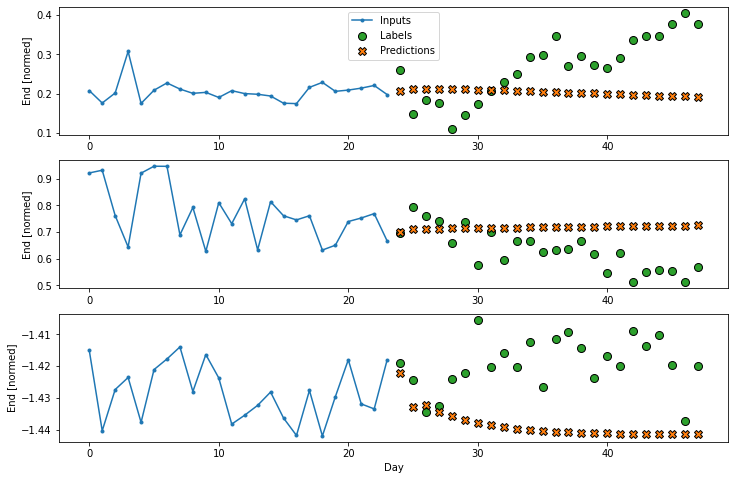

In [100]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

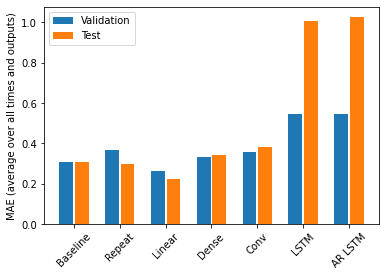

In [101]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [102]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Baseline: 0.3065
Repeat  : 0.2974
Linear  : 0.2262
Dense   : 0.3445
Conv    : 0.3848
LSTM    : 1.0073
AR LSTM : 1.0264


사실상 정확도를 판단하는건 MSE를 통해서 얼마나 실제값과 차이가 나냐 그걸 따져야하는 것 아닌가